In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
all_CA = pd.read_csv("all_CA.csv")
all_CA

,STATEFP10,COUNTYFP10,TRACTCE10,BLOCKCE10,GEOID10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,HOUSING10,POP10
0,6,1,410000,2024,60014100002024,1180,0,37.751450,-122.124449,0,0
1,6,1,407300,2017,60014073002017,553,0,37.770044,-122.209980,0,0
2,6,1,408100,2011,60014081002011,11797,0,37.794582,-122.182080,0,0
3,6,1,401000,2002,60014010002002,598,0,37.834348,-122.269994,0,0
4,6,1,406100,1005,60014061001005,139,0,37.778308,-122.227309,0,0
...,...,...,...,...,...,...,...,...,...,...,...
710140,6,115,41100,4004,61150411004004,583474,0,39.490387,-121.295868,3,4
710141,6,115,41100,3015,61150411003015,31015,0,39.455425,-121.268718,0,0
710142,6,115,41100,2032,61150411002032,80959,0,39.378173,-121.264575,0,0
710143,6,115,41100,2063,61150411002063,31921,0,39.376581,-121.271059,0,0


In [3]:
# calculate population density for each block
# convert ALAND10 (m^2) into sq mi
all_CA['sq_mi'] = all_CA['ALAND10'] / 2589988.11
all_CA['density'] = all_CA['POP10'] / all_CA['sq_mi']
# keep only blocks with nonzero density
df = all_CA[all_CA['density'] > 0]
df

,STATEFP10,COUNTYFP10,TRACTCE10,BLOCKCE10,GEOID10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,HOUSING10,POP10,sq_mi,density
5,6,1,405301,2002,60014053012002,2140,0,37.801053,-122.254368,98,132,0.000826,159756.275944
7,6,1,428700,1019,60014287001019,22446,0,37.789246,-122.277243,87,101,0.008666,11654.138782
11,6,1,428700,1055,60014287001055,5545,0,37.783519,-122.288688,6,26,0.002141,12144.218370
13,6,1,427700,4001,60014277004001,19338,0,37.774927,-122.287022,41,94,0.007466,12589.661927
17,6,1,427600,2001,60014276002001,1668,0,37.777080,-122.279261,6,19,0.000644,29502.262644
...,...,...,...,...,...,...,...,...,...,...,...,...,...
710129,6,115,41000,1058,61150410001058,226517,12674,39.320280,-121.249823,2,4,0.087459,45.735872
710130,6,115,41000,1021,61150410001021,1019449,0,39.314593,-121.356565,23,68,0.393611,172.759198
710133,6,115,41100,2083,61150411002083,107152,0,39.348828,-121.238508,7,17,0.041372,410.909716
710140,6,115,41100,4004,61150411004004,583474,0,39.490387,-121.295868,3,4,0.225281,17.755637


In [4]:
def get_density_distribution(in_df, density_field='density',
                             population_field='POP10', num_buckets=50):
    '''
    Given a DataFrame of small-area population and density data,
    returns a Series of the distribution of population by density.
    
    Parameters:
    -----------
    in_df : DataFrame
        DataFrame containing micro-level observations of population
        and density
    density_field : str
        Name of the field in in_df corresponding to density (default
        'density')
    population_field : str
        Name of the field in in_df corresponding to population
        (default 'POP10')
    num_buckets : int
        Number of (logarithmically distributed) buckets into which
        to group the density distribution (default 50)
    
    Returns:
    --------
    Series
        The index is the midpoint of each bucket; the value is the
        total population living at or near that density
    '''
    df = in_df.copy() # always work on a copy of the input data
    # calculate logarithmic cutpoints across the extent of the data
    cutpoints = np.logspace(np.log10(df[density_field].min()),
                            np.log10(df[density_field].max()),
                            num_buckets)
    # assign the data into buckets based on these cutpoints
    df['bucket'] = pd.cut(df[density_field], cutpoints)
    # calculate the (arithmetic) middle of each bucket to ease graphing
    df['midpoint'] = df['bucket'].apply(lambda x: x.mid)
    # group and aggregate the data, return the result
    return df.groupby('midpoint')[population_field].sum()

In [5]:
metroareas = {}

metroareas["LA"] = [37, 59, 111, 71, 65] # Los Angeles-Long Beach-Riverside, CA CSA: Los Angeles, Orange, Ventura, San Bernardino, and Riverside Counties
metroareas["SD"] = [73] # San Diego-Carlsbad-San Marcos, CA MSA: San Diego County
metroareas["SJ"] = [85, 69] # San Jose-Sunnyvale-Santa Clara, CA MSA: Santa Clara and San Benito Counties
metroareas["SF"] = [75, 1, 41, 13, 81] # San Francisco-Oakland-Fremont, CA MSA: San Francisco, Alameda, Marin, Contra Costa, and San Mateo Counties
metroareas["Fresno"] = [19, 39] # Fresno-Madera, CA CSA: Fresno and Madera Counties
metroareas["Sacto"] = [67, 61, 113, 17] # Sacramento-Arden Arcade-Roseville, CA MSA: Sacramento, Placer, Yolo, and El Dorado Counties

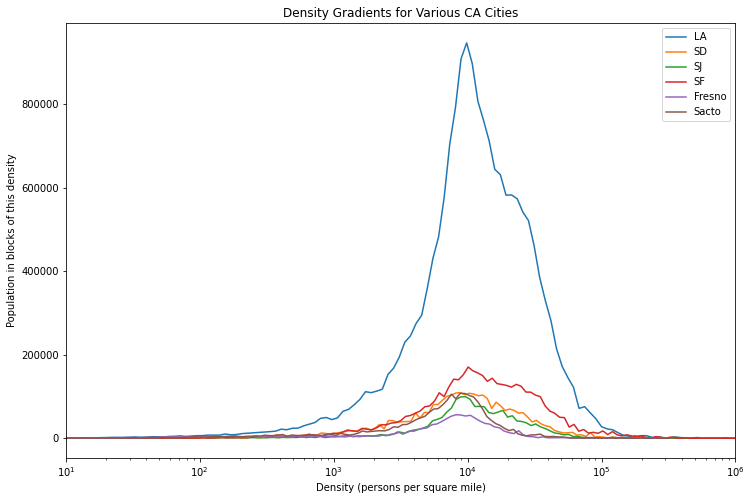

In [6]:
metrosource = {key: df[df['COUNTYFP10'].isin(value)] for key, value in metroareas.items()}
metroresults = {key: get_density_distribution(value, num_buckets=200) for key, value in metrosource.items()}

plt.figure(figsize=(12,8))
plt.xlim(10, 1000000)

for key, value in metroresults.items():
    plt.semilogx(value.index, value, label=key)

plt.xlabel('Density (persons per square mile)')
plt.ylabel('Population in blocks of this density')

plt.title("Density Gradients for Various CA Cities")

plt.legend()

plt.show()

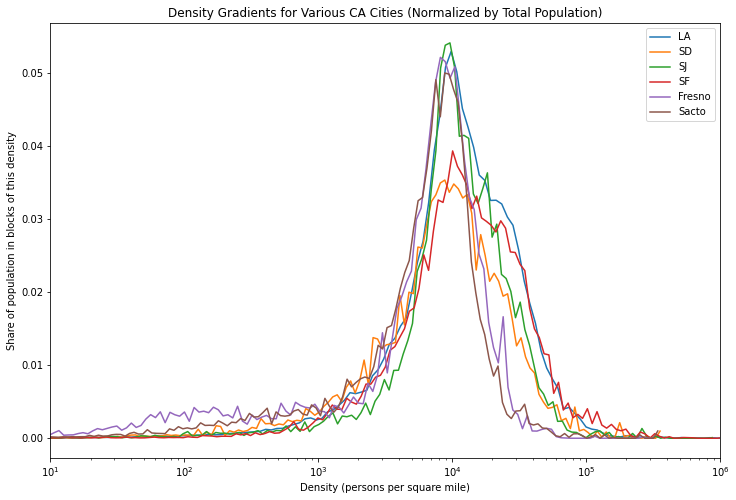

In [7]:
metropercent = {key: value / value.sum() for key, value in metroresults.items()}

plt.figure(figsize=(12,8))
plt.xlim(10, 1000000)

for key, value in metropercent.items():
    plt.semilogx(value.index, value, label=key)

plt.xlabel('Density (persons per square mile)')
plt.ylabel('Share of population in blocks of this density')

plt.title("Density Gradients for Various CA Cities (Normalized by Total Population)")

plt.legend()

plt.show()